##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Detectados, Recuperados, Fallecidos) + Contactos

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0, omega=0):
    S, E, C, I, D, R, F = SEIR

    # Poblacion
    N = S + E + C + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N - sigma * E
    # + Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    # - Los expuestos que pasan a infectados o detectados a razon `sigma`
    dC = beta_d * S * D / N - sigma * C
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # + Los contactos que pasan a infectados a razon `sigma * (1 - omega)`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E + (1 - omega) * sigma * C - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # + Los contactos que pasan a infectados a razon `sigma * omega`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I + omega * sigma * C - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dC, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Detectado - Infectado Detectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Contacto - Expuesto Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  
Nuevos Parametros:  
    * `omega` por ahora es el % de efectividad de la medida de seguimiento de contactos


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 7.
razon_mortalidad = 3.4 / 100.0 # OMS, best fit

infectados_t0 = 16. # Best fit
susceptibles_t0 = 11e6

data = load_data()

In [3]:
def run_model(params):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
        
    if len(params) > 3:
        params = params[::-1]
        omega, theta, *R_ts = params
        
        R_ts = R_ts[::-1]
        R0 = R_ts[0]
        
        beta = [R_t / periodo_infeccioso for R_t in R_ts]
    else:
        R0, theta, omega = params
        beta = R0 / periodo_infeccioso
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0, # expuestos
        0, # contactos
        infectados_t0,
        0, 0, 0 # detectados, recuperados, fallecidos
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = beta,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / (periodo_infeccioso * 1.5),
        theta = theta / periodo_infeccioso,
        beta_d = 1. / periodo_infeccioso,
        omega = omega,
        days = days,
        step = 1
    )

days = int(365 * 1.4)

omega_range = np.arange(start=0., stop=1.0, step=0.033)
theta_range_adjusted = np.arange(start=0.25, stop=.75, step=0.0165)
ranged_complete_solutions = {}

for R0 in np.arange(1.4, 4.2, 1.4):
    for theta in theta_range_adjusted:
        solutions = [
            (omega, run_model((R0, theta * R0, omega))) for omega in omega_range
        ]

        key = '{:.1f}'.format(R0)
        complete_solutions = ranged_complete_solutions.get(key, [])
        complete_solutions.append(solutions)
        ranged_complete_solutions[key] = complete_solutions

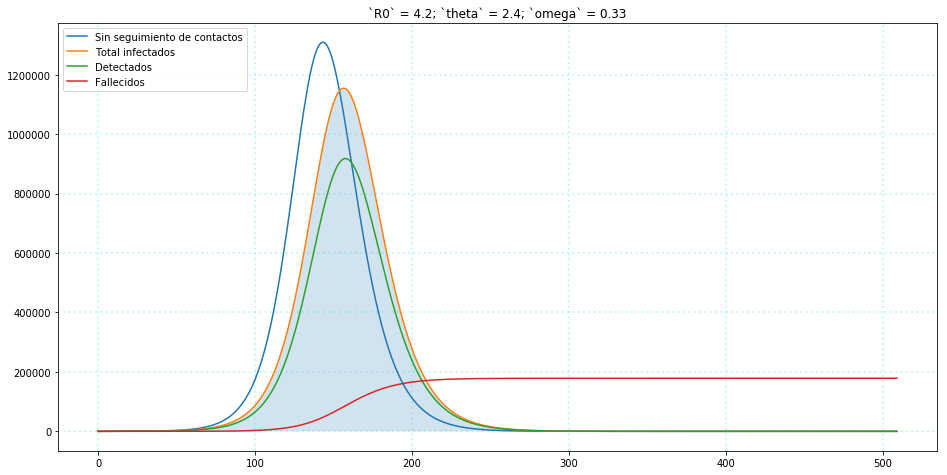

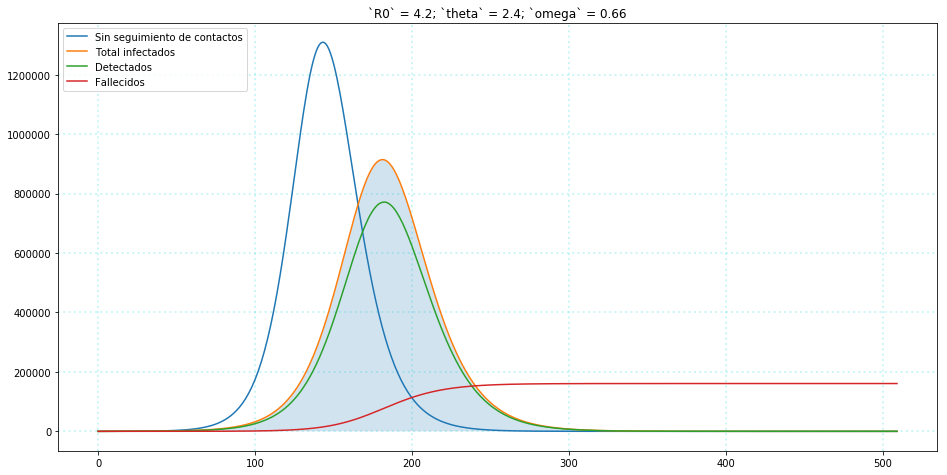

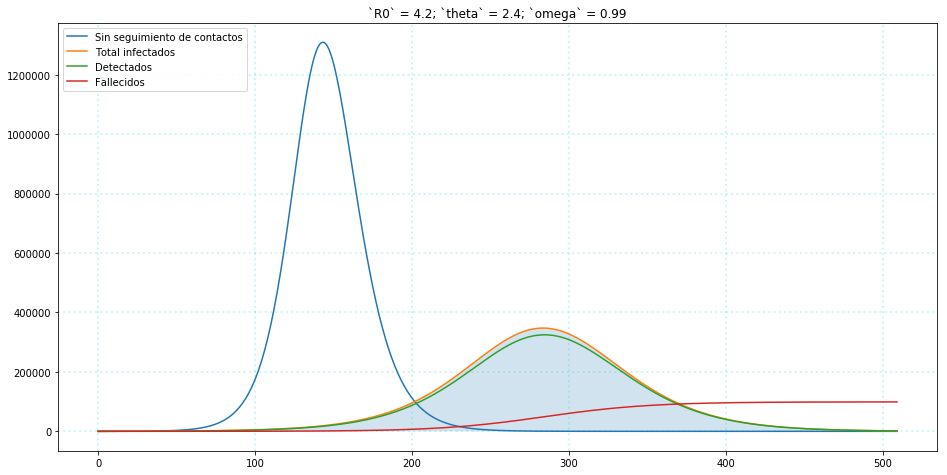

In [4]:
effective_r0 = 4.2
complete_solutions = ranged_complete_solutions[str(effective_r0)]
effective_theta = theta_range_adjusted[20] * effective_r0
solutions = complete_solutions[20]

solutions_x = solutions[0][1]['t']
solution_base = np.sum(solutions[0][1]['y'][2:5], axis=0)

for _ in range(10, len(omega_range), int(len(omega_range) / 3)):
    solution_infected = np.sum(solutions[_][1]['y'][2:5], axis=0)

    ax = plot(solutions_x, solution_base, labels=['Sin seguimiento de contactos'])
    ax.plot(solutions_x, solution_infected, label='Total infectados')
    ax.plot(solutions_x, solutions[_][1]['y'][2] + solutions[_][1]['y'][4], label='Detectados')
    ax.plot(solutions_x, solutions[_][1]['y'][-1], label='Fallecidos')
    ax.fill_between(
        solutions_x,
        [0] * len(solutions_x),
        solution_infected,
        alpha=0.2
    )
    ax.set_title('`R0` = {:.1f}; `theta` = {:.1f}; `omega` = {:.2f}'.format(
        effective_r0,
        effective_theta, 
        solutions[_][0])
    )
    ax.legend(loc='upper left')

`omega` esta relacionado a la definicion de contacto y a la capacidad de hacer el seguimiento.  
TODO: Cuantos y como se distribuye la cantidad de contactos?

La curva `Sin seguimiento de contactos` se genera a partir de un `R0` = 4.2; `theta` = 2.4; `omega` = 0.  

###### Cual es la capacidad de seguimiento de contactos necesaria? como afecta a la curva de contagios?  

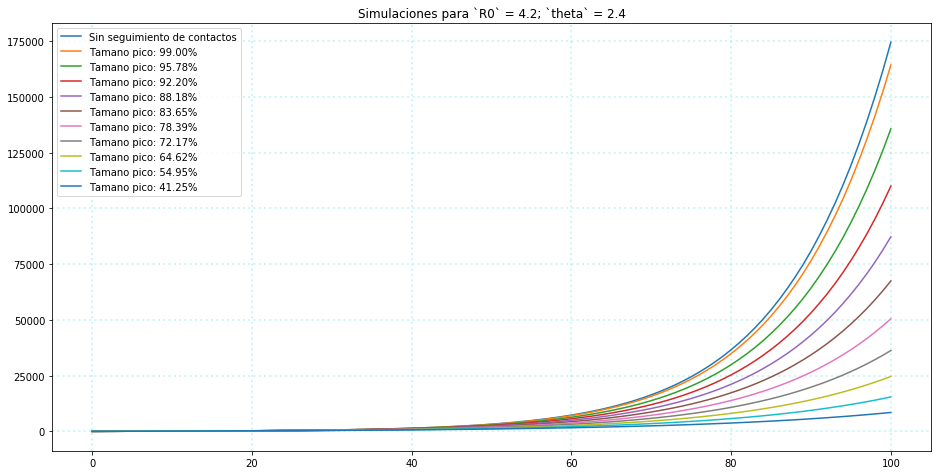

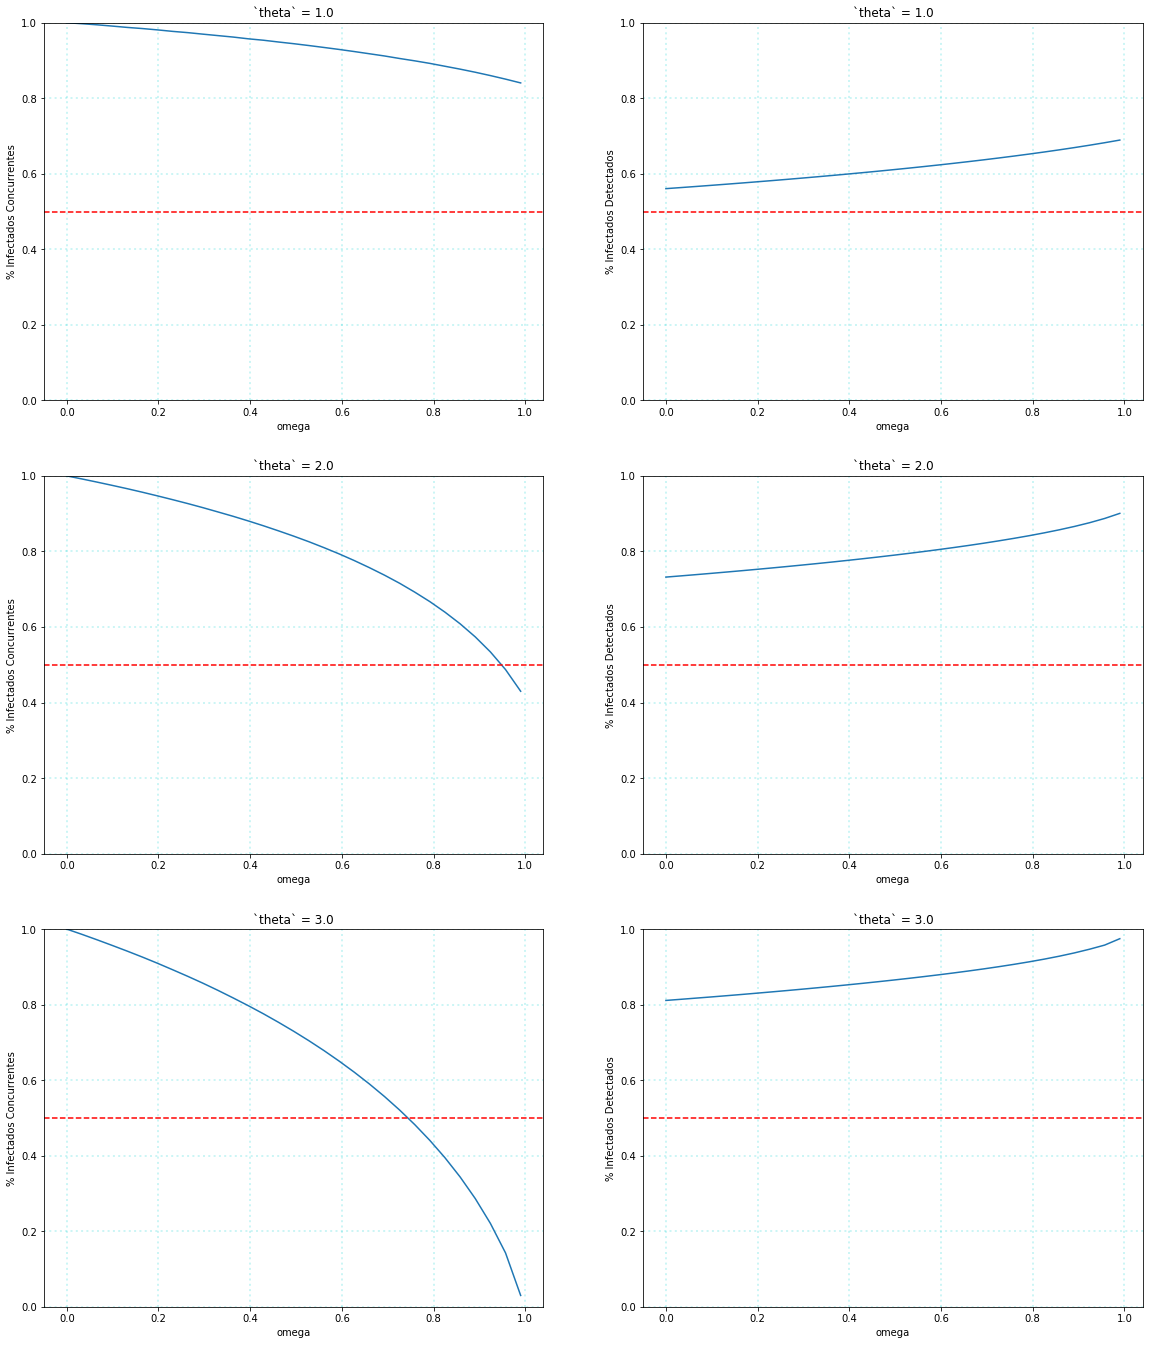

In [5]:
def get_metrics(solutions):
    solution_base = solutions[0][1]['y'][2] + solutions[0][1]['y'][3] + solutions[0][1]['y'][4]
    total_infected = [
        np.sum(solutions[_][1]['y'][2:5], axis=0) for _ in range(len(solutions))
    ]
    concurrent_infected = [
        max(total_infected[_]) / max(solution_base) for _ in range(len(solutions))
    ]
    percentage_detected = [
        sum(
            solutions[_][1]['y'][2] + solutions[_][1]['y'][4]
        ) / sum(total_infected[_]) for _ in range(len(solutions))
    ]
    
    return (concurrent_infected, percentage_detected)

to_day = len(data[0]) + 30
solutions_x_capped = solutions_x[:to_day]

ax = plot(solutions_x_capped, solution_base[:to_day], labels=['Sin seguimiento de contactos'])
ax.set_title('Simulaciones para `R0` = {:.1f}; `theta` = {:.1f}'.format(effective_r0, effective_theta))

concurrent_infected, _ = get_metrics(solutions)

for _ in range(1, len(solutions), int(len(solutions)/10)):
    solution_infected =  solutions[_][1]['y'][2] +  + solutions[_][1]['y'][3] + solutions[_][1]['y'][4]
    ax.plot(
        solutions_x_capped,
        solution_infected[:to_day],
        label='Tamano pico: {:.2f}%'. format(concurrent_infected[_] * 100)
    )
    ax.legend(loc='upper left')


labels = ['% Infectados Concurrentes', '% Infectados Detectados']
fig, axs = pyplot.subplots(figsize=(50 / 2.54, 3 * 20 / 2.54), ncols=2, nrows=3)

# Simulaciones para `theta` = 1, 2 y 3
for solution_idx in range(0, len(theta_range_adjusted), int(len(theta_range_adjusted) / 2)):
    metrics = get_metrics(complete_solutions[solution_idx])
    ax_row = axs[int(solution_idx / 15)]
    
    for idx, ax in enumerate(ax_row):
        ax.plot(omega_range, metrics[idx])
        ax.axhline(y=0.5, color='r', linestyle='--')
        ax.set(xlabel='omega', ylabel=labels[idx])
        ax.set_title('`theta` = {}'.format(1 + solution_idx / 15))
        ax.set_ylim(bottom=0, top=1.)
        ax.grid( color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)


TODO: Describir; Terminar de responder  
Hasta aqui fue achatar la curva (Reduccion en % de infectados concurrentes)

###### Bajo que circunstancias se pueden aflojar las restricciones?

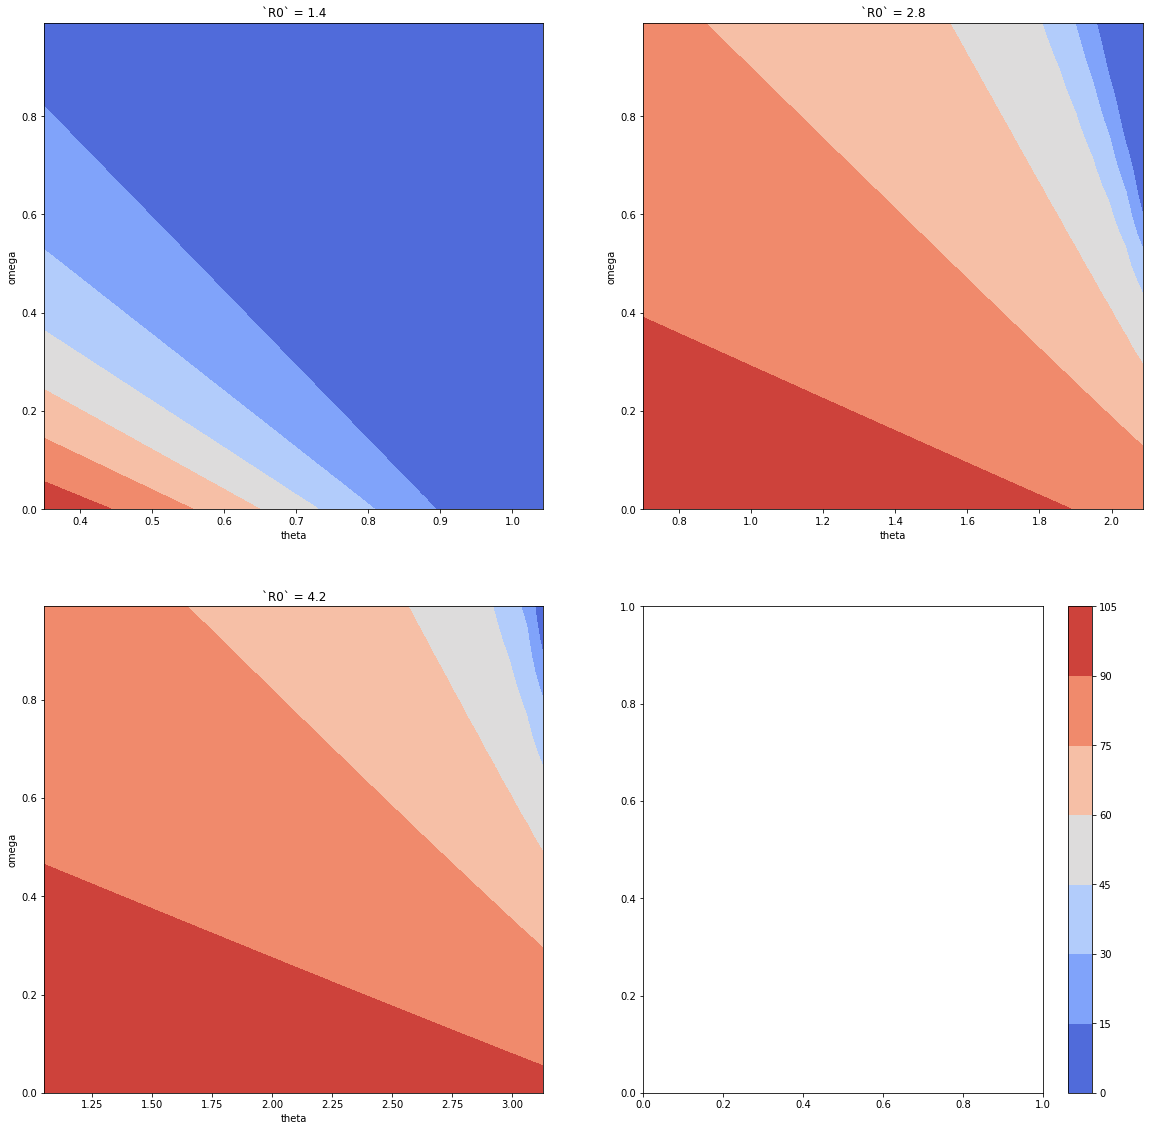

In [6]:
from matplotlib import cm

fig, axs = pyplot.subplots(figsize=(50 / 2.54, 2 * 25 / 2.54), ncols=2, nrows=2)

for idx, R0 in enumerate(ranged_complete_solutions.keys()):
    complete_solutions = ranged_complete_solutions[R0]
    contour_data = np.array([[
        solutions[_][1]['y'][-1][-1] for _ in range(len(solutions))] for solutions in complete_solutions
    ])
    contour_data = contour_data / np.max(contour_data) * 100

    ax = axs[int(idx / 2)][idx % 2]
    fcountour = ax.contourf(
        theta_range_adjusted * float(R0), omega_range, contour_data, cmap=cm.coolwarm, 
    )
    ax.set(xlabel='theta', ylabel='omega')
    ax.set_title('`R0` = {}'.format(R0))
    
cbar = fig.colorbar(fcountour)

Relacion entre `omega` (0 - 100%), `theta` (25 - 75%) y la cantidad de fallecidos (Cambio %).  
<b>Los `R0` no son efectivos, se los toma como iniciales, esto es, sin pruebas y sin seguimiento de contactos</b>

![Intervenciones](./img/1.png)
<center>Efecto estimado de las intervenciones del gobierno en el reino unido</center>

Notas: 
* 105 es un artefecto de la libreria de graficado, el valor es 100 y es porcentaje.
* El efecto de hacer pruebas y aislar a los infectados en la mortalidad del virus era obvio, achatar la curva reduce el estres al sistema de salud, pero una reduccion significativa en la mortalidad solo se da cuando se incurre en grandes esfuerzos de prueba, seguimiento de contactos y aislacion cuando se reducen las intervenciones del gobierno.

###### Regresion 

Tal vez el mayor problema en la regresion hasta ahora es la definicion de `detectado`, "un `detectado` transmite el virus solo a un `susceptible`", entonces, en vez de preguntarse cuantos `infectados` no detectados hay respecto a los `detectados`.   
Una mejor pregunta que podria hacerse es "Que porcentaje de `infectados` fueron detectados antes de transmitir la enfermedad a mas de un `susceptible`?".

In [7]:
days = [15, len(data[0]) - 15]
razon_mortalidad = 2. / 100.0
data = np.array(data)

def naive_lmfit(R0_max):
    params = lmfit.Parameters()
    params.add('R0', value=3., min=2., max=R0_max * 1.5)
    params.add('R1', value=2., min=.6, max=R0_max)
    params.add('theta', value=2., min=R0_max * .1, max=R0_max)
    params.add('omega', value=.5, min=.25, max=.75)
    
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
        solution_data[4] = np.sum(solution_data[2:5], axis=0)
        
        return (solution_data[(4, 6),] - data[(0, 2),]) * np.array([[
            1. / sum(data[0]), 
            10. / sum(data[2])
        ]]).T
#         return (solution_data[(6),] - data[(2),])

    return lmfit.minimize(sqsum, params, method='differential_evolution')

R_ts = naive_lmfit(4.)
R_ts
# data

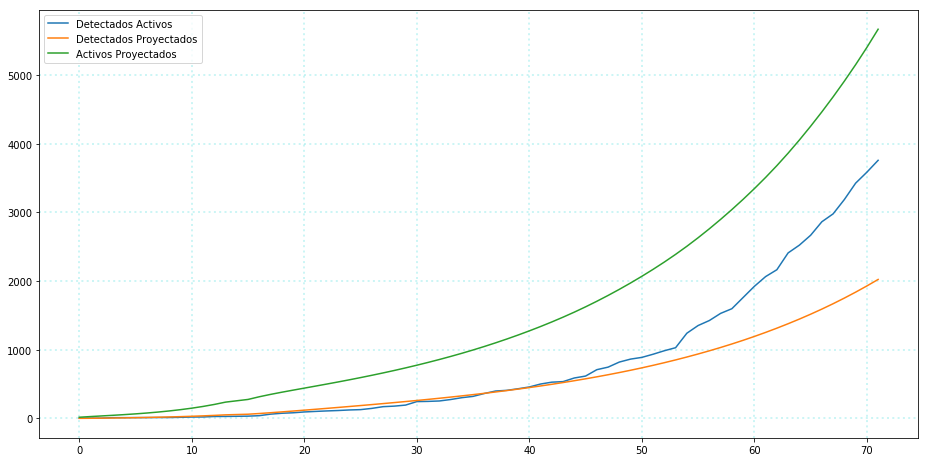

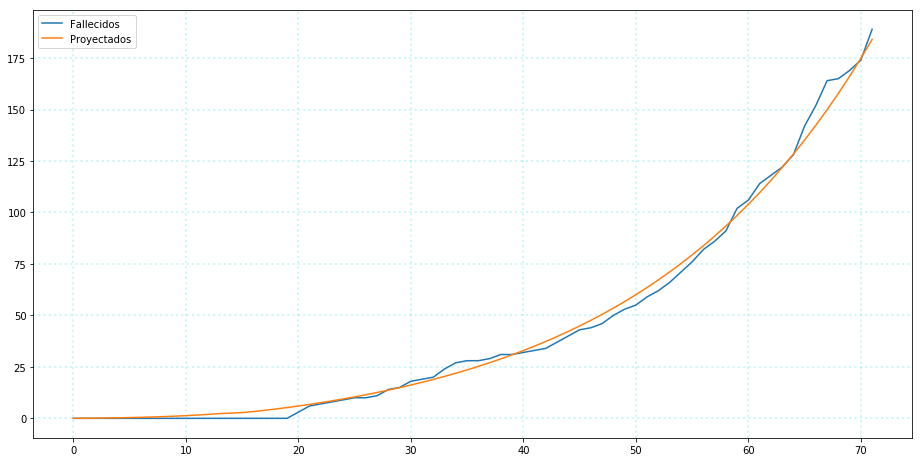

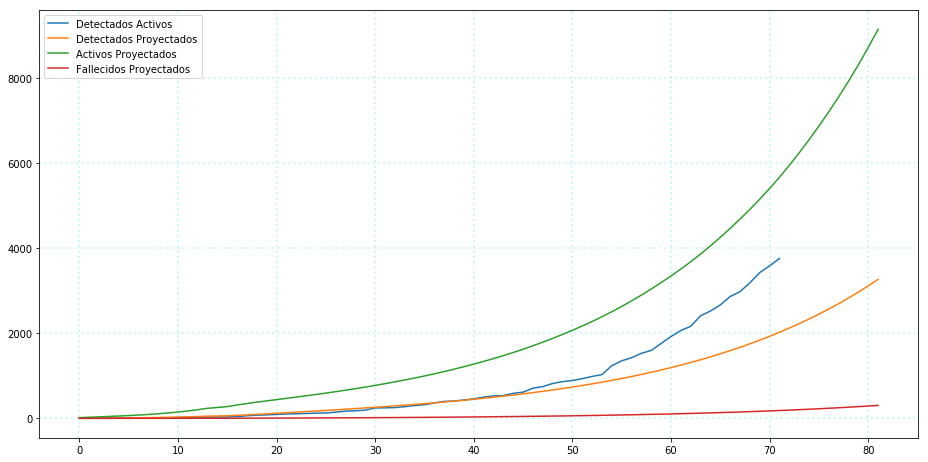

In [14]:
days = [15, len(data[0]) - 15]

solution = run_model(R_ts.params)
concurrent_infected = np.sum(solution['y'][2:5], axis=0)

plot(
    solution['t'], 
    data[0], solution['y'][2] + solution['y'][4], concurrent_infected,
    labels=[
        'Detectados Activos', 'Detectados Proyectados', 'Activos Proyectados',
    ]
)

plot(
    solution['t'], 
    data[2],  solution['y'][6],
    labels=[
        'Fallecidos', 'Proyectados'
    ]
)

days = [15, len(data[0]) - 15 + 10]
solution = run_model(R_ts.params)
concurrent_infected = np.sum(solution['y'][2:5], axis=0)

_ = plot(
    solution['t'], 
    data[0], solution['y'][2] + solution['y'][4], concurrent_infected, solution['y'][6],
    labels=[
        'Detectados Activos', 
        'Detectados Proyectados', 
        'Activos Proyectados', 
        'Fallecidos Proyectados'
    ]
)

avg: 1.6176731505673883 +- 0.4125160233096111
lat: 1.0868114113024316 +- 0.16508526712385807


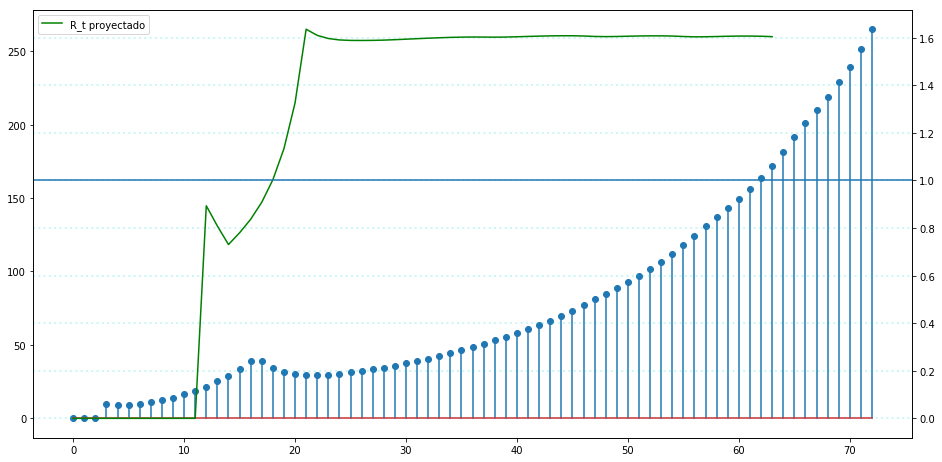

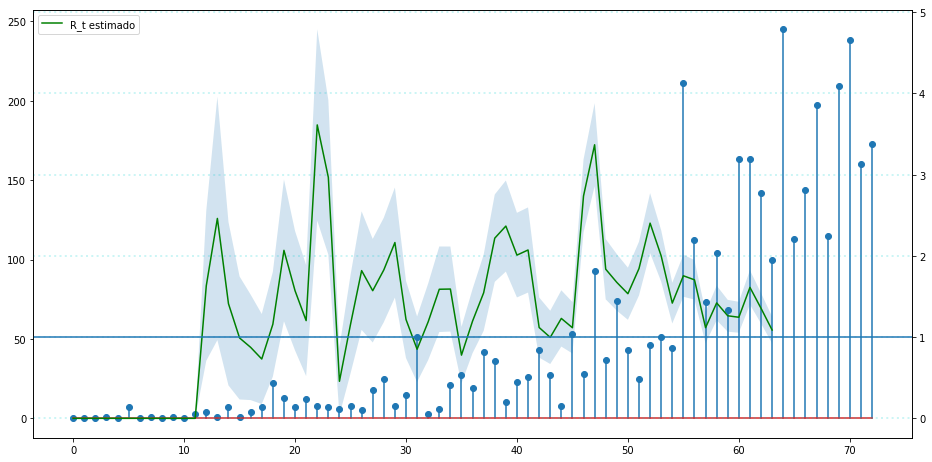

In [13]:
import scipy.signal
import scipy.stats

new_projected_cases = np.diff(
    np.sum(solution['y'][2:5], axis=0), 
    prepend=[solution['y'][3][0]]
)[:len(data[0])]

fig, ax = pyplot.subplots()
ax.stem([0] * 2 + list(new_projected_cases), label='Casos Diarios Proyectados')

non_recovered = np.diff(
    np.sum(solution['y'][1:5], axis=0), 
    prepend=[solution['y'][3][0]]
)[:len(data[0])]

profile = np.array(int(periodo_infeccioso) * [1] + int(periodo_incubacion) * [0])
profile = profile / sum(profile)
r_ts, _, _ = estimate_rt(
    non_recovered,
    infectivity_profile = profile
)

ax2 = ax.twinx()
_ = ax2.plot(r_ts, color='green', label='R_t proyectado')
ax2.axhline(1.)
ax2.legend(loc='upper left')

pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

new_cases = np.diff(data[0], prepend=[data[0][0]])
new_cases[new_cases < 0.] = 0.

fig, ax = pyplot.subplots()
ax.stem([0] * 2 + list(new_cases), label='Casos Diarios Estimados')

r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=2)

ax2 = ax.twinx()
_ = ax2.plot(r_ts, color='green', label='R_t estimado')
ax2.fill_between(
    range(len(r_ts)),
    r_ts_min,
    r_ts_max,
    alpha=0.2
)
ax2.axhline(1.)
ax2.legend(loc='upper left')

pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

print('avg: {} +- {}\nlat: {} +- {}'.format(
    np.mean(r_ts[r_ts > 0]), np.mean(r_ts_max - r_ts),
    r_ts[-1], r_ts_max[-1] - r_ts[-1]
))

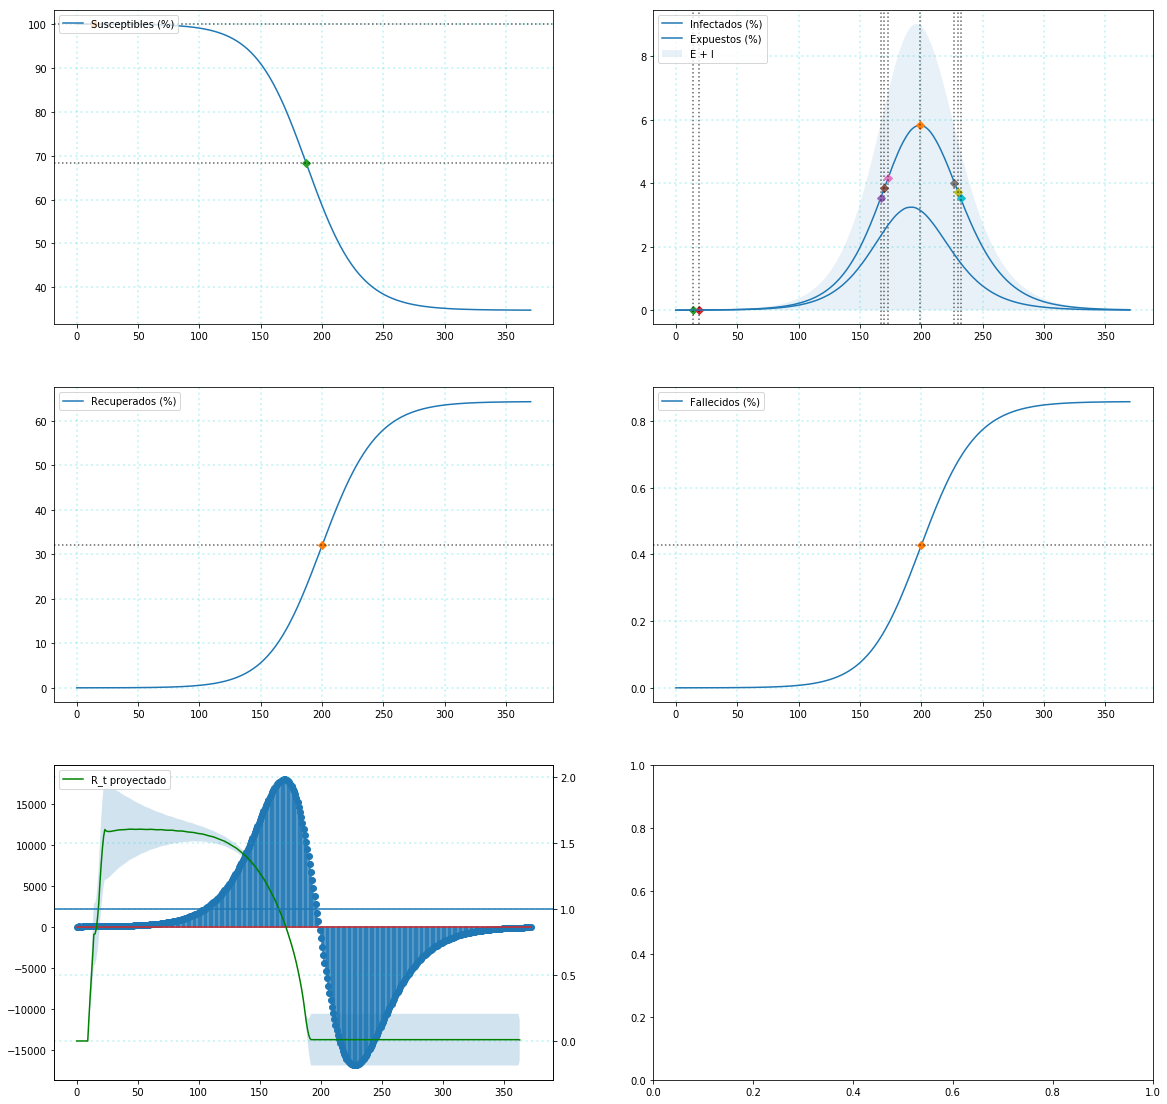

In [10]:
days = [15, len(data[0]) - 15 + 300]
solution = run_model(R_ts.params)

_ = describe_simulation({
    'susceptible': solution['y'][0],
    'exposed': solution['y'][1],
    'infected': np.sum(solution['y'][2:5], axis=0),
    'recovered': solution['y'][5],
    'death': solution['y'][6]
}, infectivity_profile=profile)
        
# draw_curve_inflection(solution['y'][3] + solution['y'][4], direction='v')

Notas:
* buena joda como el Rt efectivo del fitting es cercano al promedio del Rt estimado de los datos
* es necesario aplicar un delay en recuperados y fallecidos?

Que hacer ahora?
* Lo faltante de otros notebooks
    * Asintomaticos, Pre-Sintomaticos, Serial Interval - dos opciones, o crear una clase o mejor permitir que los expuestos infecten a una `razon asintomatica` << `beta`.
    * Fallo de las pruebas
        * Falsos positivos - esto es introducir a susceptibles a entornos de altisima exposicion
        * Falsos negativos - esto ya esta a medio tratar con `theta` que abarca fallo en los tests, capacidad de pruebas insuficiente o algun factor social; otra restriccion a la clase de `Detectados` es que son `Infectados` tempranamente identificados, esto es, antes que transmitan la enfermedad a mas de `beta_d` otros `Susceptibles`; Se podria separar `beta_d` para mostrar la utilidad de los centros de aislamiento de forma mas explicita.
    * Por ahora la idea de diferentes criticidades de `Infectados` no esta implementada, la capacidad hospitalaria no pareceria poder estimarse mas alla de una relacion con `Fallecidos`, la idea basica de achatar la curva fue evitar el colpaso del sistema sanitario, <b>como agregar esto?</b>
       * `theta` o `mu` dinamicos?
    * Re-susceptibilidad
* Agregar estructura
* Agregar alguna libreria para evaluar la regresion